In [ ]:
%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4)

from util import util
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import label_binarize

import numpy as np
import pandas as pd
import xgboost
data_folder = os.path.join('../..', 'data')
file_name = "DataForModel"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
data = util.load_data(data_folder, file_name)
data = data[data['Div'] == 'E0']
data = data[(data['ELO diff'] > 100) | (data['ELO diff'] < -100)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3260 entries, 6 to 32527
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Div                             3260 non-null   object        
 1   Date                            3260 non-null   datetime64[ns]
 2   HomeTeam                        3260 non-null   object        
 3   AwayTeam                        3260 non-null   object        
 4   FTHG                            3260 non-null   float64       
 5   FTAG                            3260 non-null   float64       
 6   Season                          3260 non-null   object        
 7   ELO diff                        3260 non-null   float64       
 8   Home_prob_ELO                   3260 non-null   float64       
 9   Draw_prob_ELO                   3260 non-null   float64       
 10  Away_prob_ELO                   3260 non-null   float64       
 11  Diff_goa

In [95]:
x_cols = ['ELO diff', 'Home_prob_ELO', 'Draw_prob_ELO', 'Away_prob_ELO',
       'Diff_goals_scored', 'Diff_goals_conceded', 'Matchrating',
       'Diff_points', 'Diff_change_in_ELO', 'Diff_opposition_mean_ELO',
       'Diff_shots_on_target_attempted', 'Diff_shots_on_target_allowed',
       'Diff_shots_attempted', 'Diff_shots_allowed', 'Diff_corners_awarded',
       'Diff_corners_conceded', 'Diff_fouls_commited', 'Diff_fouls_suffered',
       'Diff_yellow_cards', 'Diff_red_cards']
data["Outcome"] = data.apply(
    lambda row: (
        1 if row["FTHG"] > row["FTAG"] else (0 if row["FTHG"] == row["FTAG"] else -1)
    ),
    axis=1,
)
y_cols = ['Outcome']
X = data[x_cols]
y = data[y_cols]

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Training accuracy: 0.6192484662576687
Test accuracy: 0.6380368098159509
AUC for class -1: 0.79
AUC for class 0: 0.52
AUC for class 1: 0.78
Classification Report:
               precision    recall  f1-score   support

          -1       0.56      0.79      0.65       215
           0       0.25      0.01      0.02       114
           1       0.71      0.76      0.74       323

    accuracy                           0.64       652
   macro avg       0.51      0.52      0.47       652
weighted avg       0.58      0.64      0.58       652



/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

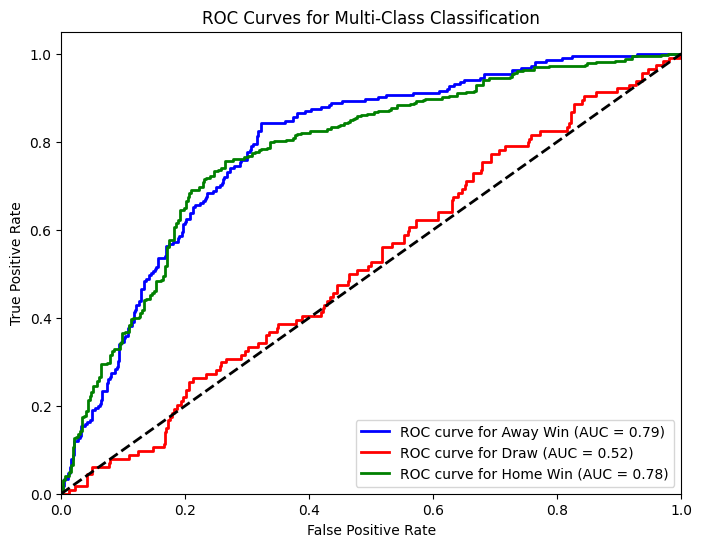

In [99]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

# Evaluate the model
print("Training accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

# Compute AUC per class
y_pred_prob = model.predict_proba(X_test)
for i, class_label in enumerate(model.classes_):
    auc_score = roc_auc_score(y_test == class_label, y_pred_prob[:, i])
    print(f"AUC for class {class_label}: {auc_score:.2f}")

# Make predictions
y_pred = model.predict(X_test)


# Generate classification report
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

util.plot_multi_class_roc(
    y_test, y_pred_prob, classes=[-1, 0, 1], class_names=["Away Win", "Draw", "Home Win"]
)


In [76]:
y_test_binarized = label_binarize(
    y_test, classes=[-1, 0, 1]
)  # Adjust class labels as needed

auc_per_class = roc_auc_score(y_test_binarized, y_pred_prob, average=None)


In [100]:
data = data[(data['ELO diff'] > 100) | (data['ELO diff'] < -100)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3260 entries, 6 to 32527
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Div                             3260 non-null   object        
 1   Date                            3260 non-null   datetime64[ns]
 2   HomeTeam                        3260 non-null   object        
 3   AwayTeam                        3260 non-null   object        
 4   FTHG                            3260 non-null   float64       
 5   FTAG                            3260 non-null   float64       
 6   Season                          3260 non-null   object        
 7   ELO diff                        3260 non-null   float64       
 8   Home_prob_ELO                   3260 non-null   float64       
 9   Draw_prob_ELO                   3260 non-null   float64       
 10  Away_prob_ELO                   3260 non-null   float64       
 11  Diff_goa

In [ ]:
X = data[x_cols]
y = data[y_cols]